# NDVI Anomaly
Notebook to generate NDVI anomaly, showing changes in NDVI between two time periods. To show actual change two time period of similar seasonality should be used. 
The output is an NDVI anomaly and also a threshold product, the thresholds assocaited with the product can be adjusted depending on what you changes the user is interested in. 

Adapted from https://github.com/ceos-seo/data_cube_notebooks for us in Satellite Applications Catapult Common Sensing DataCube

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

## Install requirements

In [1]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [2]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

from matplotlib.cm import RdYlGn, Greens

CMAP = "Blues"

In [3]:
#import datacube utilities
import datacube_utilities.data_access_api as dc_api  
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask

# NDVI Anomaly 
Adapted from https://github.com/ceos-seo/data_cube_notebooks for us in Satellite Applications Catapult Common Sensing DataCube

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

# Choose Platform and Product

In [4]:
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='ndvi anomoly')

## Set Variables

In [5]:
#area of interest: load in as wkt
#smallish area for testing
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#larger area for testing
#aoi_wkt = "POLYGON((177.43329863711836 -17.52948354640883,177.76975493594648 -17.52948354640883,177.76975493594648 -17.826499420595315,177.43329863711836 -17.826499420595315,177.43329863711836 -17.52948354640883))"
#set-project: This is the same for all of FIJI so this may not need to be a variable within the Fijian cube.
output_projection = "EPSG:32760"
#set resolution_if using Landsat min 30m, if sentinel min 10m 
res = (3000)
#platform is the sensor, options include 'LANSAT_8', 'LANSAT_7', 'LANSAT_5', 'LANSAT_4', 'SENTINEL_2'
platform_base = 'LANDSAT_8'
platform_analysis = 'LANDSAT_8'



In [6]:
xcoord = (2026601, 2133765)
ycoord = (3999978, 4110240)
inputCrs = 'EPSG:3460'

In [7]:
#set baseline start and end of period
baseline_start_date = '2015-3-1'
baseline_end_date = '2015-9-1'

#set the analysis start and end of period
analysis_start_date = '2016-3-1'
analysis_end_date = '2016-9-1'

# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
mosaic_type = "median"

### Create AOI

In [8]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

## Translate inputs and load data

In [10]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
    else:
        print("invalid platform")
    return product, measurements 

In [11]:
baseline_product, baseline_measurement = create_product_measurement(platform_base)
analysis_product, analysis_measurement = create_product_measurement(platform_analysis)

In [12]:
#create resolution
resolution = (-res, res)

In [13]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)

print(baseline_time_period)

(datetime.date(2015, 3, 1), datetime.date(2015, 9, 1))


### Import products from datacube 

In [14]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'x': xcoord,
    'y': ycoord,
    'crs': inputCrs,
    #'y': lat_extents,
    #'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution
}

>#### Load Data ( Baseline, Analysis) 

In [15]:
baseline_ds = dc.load(
    time = baseline_time_period,
    platform = platform_base,
    product = baseline_product,
    measurements = baseline_measurement,
    **query
)

In [16]:
analysis_ds = dc.load(
    time = analysis_time_period,
    platform = platform_analysis,
    product = analysis_product,
    measurements = analysis_measurement,
    **query
)

### Check if loads are valid

In [43]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [45]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [46]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

#### Create Cloud Mask
Generating boolean masks that highlight valid pixels
Pixels must be cloud-free over land or water to be considered

In [47]:
#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform_base)
analysis_clean_mask = landsat_qa_clean_mask(analysis_ds, platform_analysis)

In [48]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

### Perform Mosaic
 Use clean masks in a time series composite

In [49]:
#add in geomedian - get rid of others
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [50]:
new_compositor = mosaic_function[mosaic_type]


In [51]:
baseline_composite = new_compositor(baseline_ds, clean_mask = baseline_clean_mask)
analysis_composite = new_compositor(analysis_ds, clean_mask = analysis_clean_mask)

### Mask out Water

In [52]:
water_class_base = wofs_classify(baseline_composite, mosaic=True, x_coord='x', y_coord='y').wofs
baseline_composite = baseline_composite.copy(deep=True).where((baseline_composite != np.nan) & (water_class_base == 0))
water_class_analy = wofs_classify(analysis_composite, mosaic=True, x_coord='x', y_coord='y').wofs
analysis_composite = analysis_composite.copy(deep=True).where((analysis_composite != np.nan) & (water_class_analy == 0))

(<Figure size 720x701.053 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe6b8ede9e8>)

<Figure size 432x216 with 0 Axes>

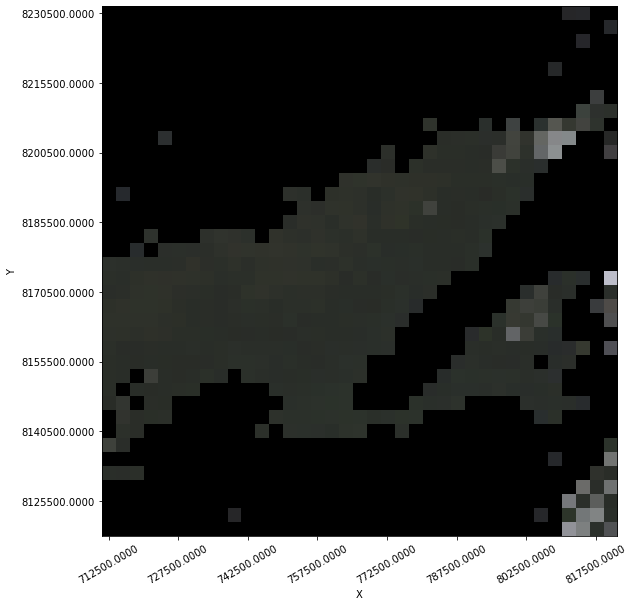

In [53]:
plt.figure(figsize = (6,3))
rgb(baseline_composite, x_coord='x', y_coord='y')

(<Figure size 720x701.053 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe6b40ad8d0>)

<Figure size 432x216 with 0 Axes>

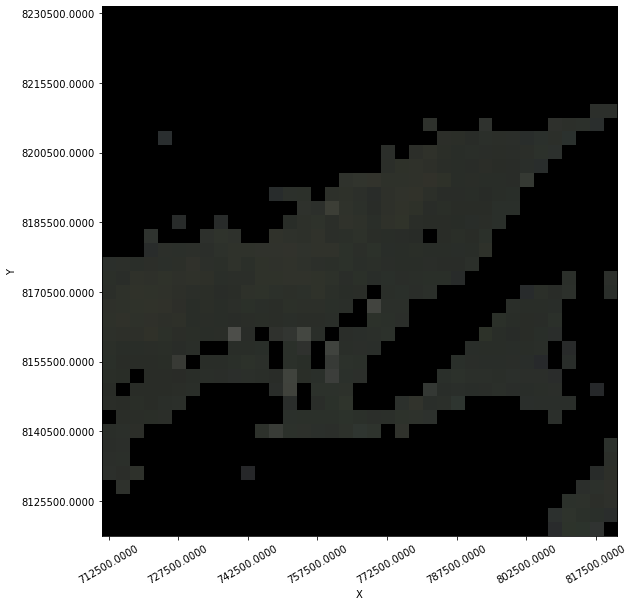

In [54]:
plt.figure(figsize = (6,3))
rgb(analysis_composite, x_coord='x', y_coord='y')

### Baseline Mosaic using the NDVI Threshold Range
To only include pixels within our interest threshold range

In [55]:
def aspect_ratio_helper(ds, fixed_width = 15):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [56]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

# NDVI Anomaly

In [57]:
#calculate NDVI
ndvi_baseline_composite = NDVI(baseline_composite)
ndvi_analysis_composite = NDVI(analysis_composite)

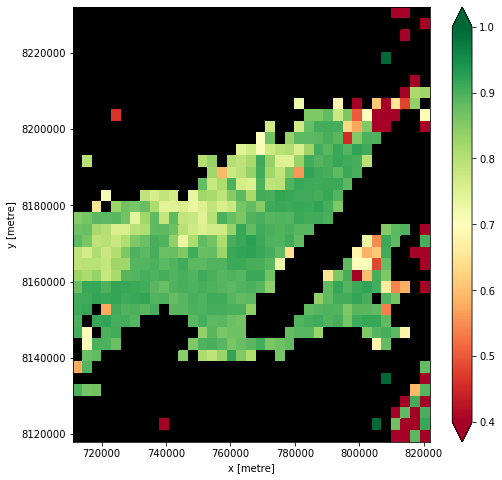

In [58]:
plt.figure(figsize = (8,8))
ndvi_baseline_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)

In [59]:
#export
ndvi_baseline_export = xr.DataArray.to_dataset(ndvi_baseline_composite, dim = None, name = 'ndvi_baseline')
write_geotiff_from_xr('ndvi_baseline.tiff', ndvi_baseline_export, ["ndvi_baseline"], crs=output_projection, x_coord = 'x', y_coord = 'y')

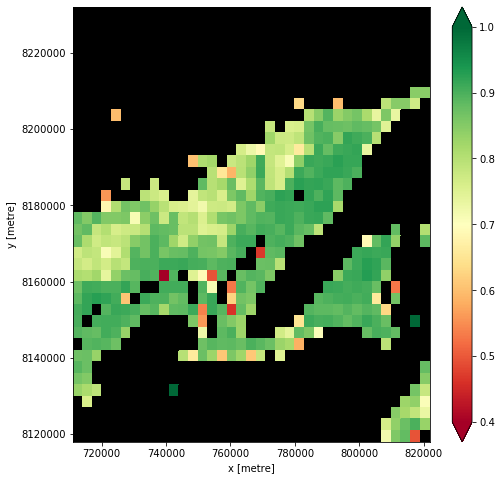

In [60]:
plt.figure(figsize = (8,8))
ndvi_analysis_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)

In [61]:
#export
ndvi_analysis_export = xr.DataArray.to_dataset(ndvi_analysis_composite, dim = None, name = 'ndvi_analysis')
write_geotiff_from_xr('ndvi_analysis.tiff', ndvi_analysis_export, ["ndvi_analysis"], crs=output_projection, x_coord = 'x', y_coord = 'y')

In [62]:
#calculate ndvi anomaly
ndvi_anomaly = ndvi_analysis_composite - ndvi_baseline_composite

NDVI Anomaly Plot


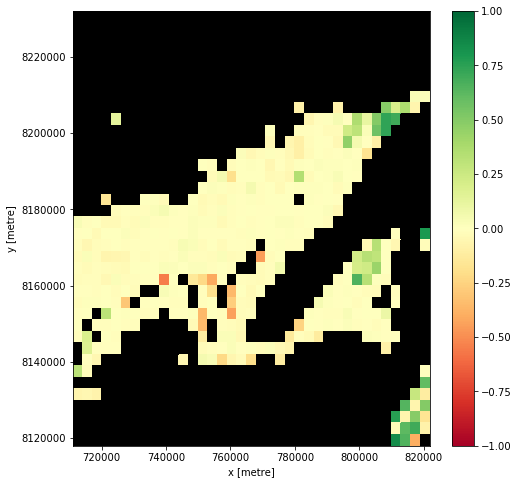

In [63]:
plt.figure(figsize = (8,8))
ndvi_anomaly.plot(vmin=-1, vmax=1, cmap = RdYlGn)

Discretized/Binned plot

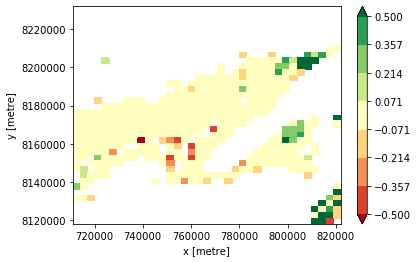

In [64]:
ndvi_anomaly.plot(levels = 8, vmin=-0.5, vmax=0.5, cmap = RdYlGn)

In [65]:
from datacube_utilities.plotter_utils import create_discrete_color_map
cmap = create_discrete_color_map(data_range=(-1,1), 
                                 th=[0.0], colors=[(240,93,94), (126,243,125)])
cmap.set_bad("black", 1.)

>#### NDVI Anomaly

This product shows the following ...<br>
BLACK = Cloud or Pixels NOT in the baseline threshold range<br>
GREEN = Pixels with an increase in NDVI<br>
RED = Pixels with a decrease in NDVI<br>

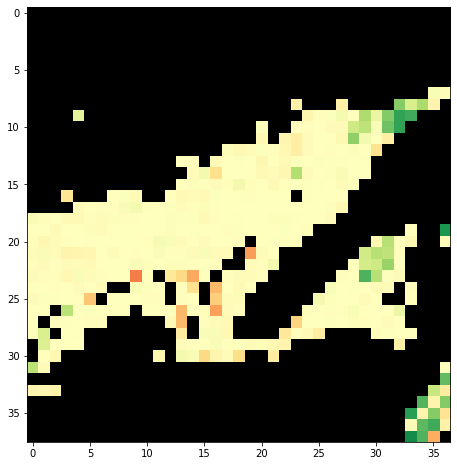

In [66]:
# plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly)) 
plt.figure(figsize = (8,8))
plt.imshow(ndvi_anomaly.values, cmap=RdYlGn, vmin=-1, vmax=1)
plt.show()

In [40]:
#export
ndvi_anomaly_export = xr.DataArray.to_dataset(ndvi_anomaly, dim = None, name = 'ndvi_anomaly')
write_geotiff_from_xr('ndvi_anomaly.tiff', ndvi_anomaly_export, ["ndvi_anomaly"], crs=output_projection, x_coord = 'x', y_coord = 'y')

---